In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

given_image = cv2.imread('./image.png')
given_gray = cv2.cvtColor(given_image, cv2.COLOR_BGR2GRAY)
my_image = cv2.imread('./ansh.png')
myrgb_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_gray = cv2.cvtColor(my_image, cv2.COLOR_RGB2GRAY)
edge_image = cv2.imread('./edge.png')
edge_gray = cv2.cvtColor(edge_image, cv2.COLOR_RGB2GRAY)
edgergb_image = cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB)


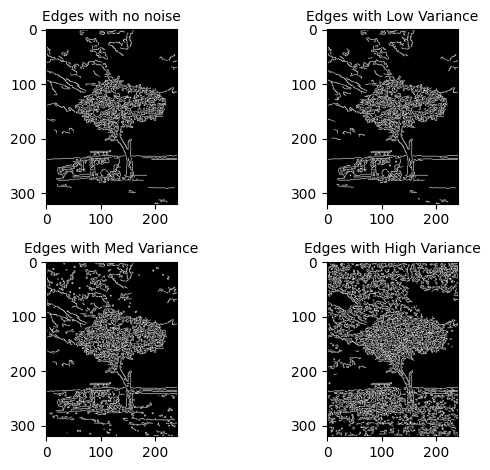

In [2]:
low_var = 0.1  # low variance
med_var = 0.2 # med variance
high_var = 0.4 # high variance
low_gauss = np.random.normal(0, (low_var**0.5),edge_image.size)
med_gauss = np.random.normal(0, (med_var**0.5),edge_image.size)
high_gauss = np.random.normal(0, (high_var**0.5),edge_image.size)

low_gauss = low_gauss.reshape(edge_image.shape[0],edge_image.shape[1],edge_image.shape[2]).astype('uint8')
med_gauss = med_gauss.reshape(edge_image.shape[0],edge_image.shape[1],edge_image.shape[2]).astype('uint8')
high_gauss = high_gauss.reshape(edge_image.shape[0],edge_image.shape[1],edge_image.shape[2]).astype('uint8')
# Add the Gaussian noise to the image
low_img = cv2.add(edge_image,low_gauss)
med_img = cv2.add(edge_image,med_gauss)
high_img = cv2.add(edge_image,high_gauss)

low_gray = cv2.cvtColor(low_img, cv2.COLOR_BGR2GRAY)
med_gray = cv2.cvtColor(med_img, cv2.COLOR_BGR2GRAY)
high_gray = cv2.cvtColor(high_img, cv2.COLOR_BGR2GRAY)

# Running the Canny Edge Detector
og_edge = cv2.Canny(edge_gray, threshold1=100, threshold2=200)
low_edges = cv2.Canny(low_gray, threshold1=100, threshold2=200)
med_edges = cv2.Canny(med_gray, threshold1=100, threshold2=200)
high_edges = cv2.Canny(high_gray, threshold1=100, threshold2=200)

# plotting the output to visualise.
_, axs = plt.subplots(2,2)
axs[0][0].imshow(og_edge, cmap='gray')
axs[0][0].set_title('Edges with no noise', fontsize = 10)
axs[0][1].imshow(low_edges, cmap='gray')
axs[0][1].set_title('Edges with Low Variance', fontsize = 10)
axs[1][0].imshow(med_edges, cmap='gray')
axs[1][0].set_title('Edges with Med Variance', fontsize = 10)
axs[1][1].imshow(high_edges, cmap='gray')
axs[1][1].set_title('Edges with High Variance', fontsize = 10)
plt.tight_layout()



# Q6 - Step 1,2,3 Functions

In [3]:
def gaussian_kernel(ksize, sigma):
    norm_constant = 1/(2 * np.pi * (sigma**2))
    output_mat = np.zeros((ksize, ksize))
    for i in range(ksize):
        for j in range(ksize):
            x = (i - (ksize-1)/2)
            y = (j - (ksize-1)/2)
            output_mat[i][j] = norm_constant * np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
    return output_mat


def transform(kernel):
    # flipping the kernel to make it different from correlation
    kernel_copy = kernel.copy()
    for x in range(kernel.shape[0]):
        for y in range(kernel.shape[1]):
            kernel_copy[x][y] = kernel[kernel.shape[0]-x-1][kernel.shape[1]-y-1]
    return kernel_copy

def convolution(img, kernel):
    # first we will tranform our kernel
    kernel = transform(kernel)
    # now find the height and width of the kernel using shape.
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    # similarly, find the height and width of the image using shape.
    img_h = img.shape[0]
    img_w = img.shape[1]
    # expanding the image and adding padded 0 on the borders in order to calculate the convolution on the edges.
    bigger_img = np.zeros((img_h+kernel_h//2 * 2, img_w+kernel_w//2 * 2))
    diff = img_h - (img_h - kernel_h//2 * 2)
    bigger_img[diff//2:img_h+(diff//2), diff//2:img_w+(diff)//2] = img[0:img_h, 0:img_w]
    # resulting image will be same shape as input image
    convolve_result = np.zeros(img.shape)
    for i in range(img_h):
        for j in range(img_w):
            convolve_result[i][j] = np.sum(kernel * bigger_img[i:i+kernel_h, j:j+kernel_w]).sum()
            # this step is the convolution product of the image with the kernel at each pixel value.
    return convolve_result


def gradient_magnitude(blur_img):
    gx = np.array([[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]])
    gy = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])
    
    convolved_gx = convolution(blur_img, gx)
    convolved_gy = convolution(blur_img, gy)
    
    grad_mag = np.sqrt(convolved_gx**2 + convolved_gy**2)
    return grad_mag


def threshold_algorithm(gradient_img, epsilon):
    curr_t = np.mean(gradient_img)
    prev_t = np.mean(gradient_img) - 1
    while np.abs(curr_t - prev_t) > epsilon:
        prev_t = curr_t
        m_high = gradient_img >= curr_t
        m_low = gradient_img < curr_t
        low = gradient_img * m_low
        high = gradient_img - low
        m_high = np.sum(high) / np.sum(m_high)
        m_low = np.sum(low) / np.sum(m_low)
        curr_t = (m_high + m_low)/2
        
    
    edge_map = (gradient_img >= curr_t) * 255
    return edge_map


# Q6 - Step 1

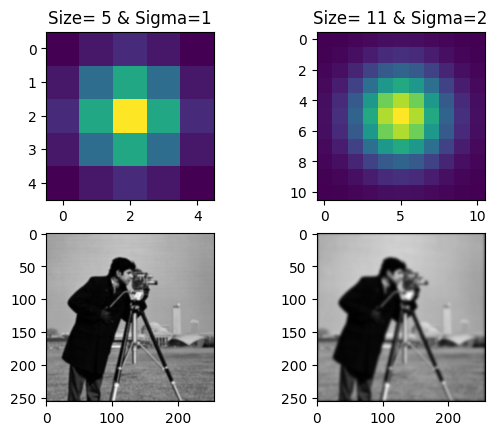

In [4]:
def step1(img):
    gauss_mattrix1 = gaussian_kernel(5,1)
    gauss_mattrix3 = gaussian_kernel(11,2)
    convolved1 = convolution(img, gauss_mattrix1)
    convolved3 = convolution(img, gauss_mattrix3)
    _, axs = plt.subplots(2, 2)
    axs[0][0].imshow(gauss_mattrix1)
    axs[0][0].set_title('Size= 5 & Sigma=1')
    axs[0][1].imshow(gauss_mattrix3)
    axs[0][1].set_title('Size= 11 & Sigma=2')
    axs[1][0].imshow(convolved1, cmap='gray')
    axs[1][1].imshow(convolved3, cmap='gray') 
    
step1(given_gray)


# Q6 - Step 4 TEST

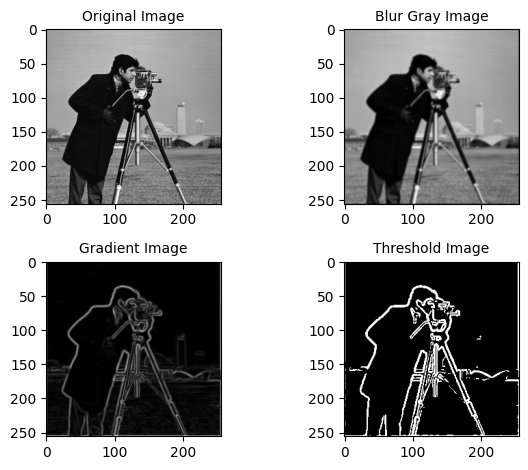

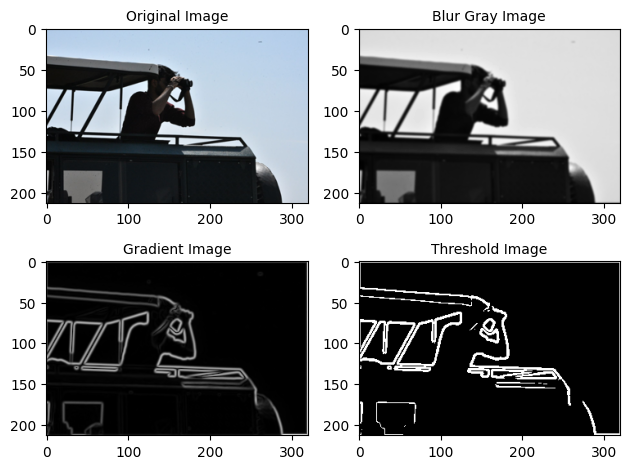

In [5]:
# First we will test the Given Image
# Step 1 
gauss_mat = gaussian_kernel(5,1)
blurgray_image = convolution(given_gray, gauss_mat)
# Step 2
gradient_image = gradient_magnitude(blurgray_image)
# Step 3
threshold_image = threshold_algorithm(gradient_image, 0.00001)
# plot for given image
_, axs = plt.subplots(2,2)
axs[0][0].imshow(given_image, cmap='gray')
axs[0][0].set_title('Original Image', fontsize = 10)
axs[0][1].imshow(blurgray_image, cmap='gray')
axs[0][1].set_title('Blur Gray Image', fontsize = 10)
axs[1][0].imshow(gradient_image, cmap='gray')
axs[1][0].set_title('Gradient Image', fontsize = 10)
axs[1][1].imshow(threshold_image, cmap='gray')
axs[1][1].set_title('Threshold Image', fontsize = 10)
plt.tight_layout()


# Now for my image repeat the same above steps
# Step 1 
gauss_mat = gaussian_kernel(5,1)
blurgray_image = convolution(my_gray, gauss_mat)
# Step 2
gradient_image = gradient_magnitude(blurgray_image)
# Step 3
threshold_image = threshold_algorithm(gradient_image, 0.00001)
# plot for given image
_, axs = plt.subplots(2,2)
axs[0][0].imshow(myrgb_image, cmap='gray')
axs[0][0].set_title('Original Image', fontsize = 10)
axs[0][1].imshow(blurgray_image, cmap='gray')
axs[0][1].set_title('Blur Gray Image', fontsize = 10)
axs[1][0].imshow(gradient_image, cmap='gray')
axs[1][0].set_title('Gradient Image', fontsize = 10)
axs[1][1].imshow(threshold_image, cmap='gray')
axs[1][1].set_title('Threshold Image', fontsize = 10)
plt.tight_layout()
